# Step 0. Read in Data and NLTK Basics


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

plt.style.use('ggplot')
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/manglampaliwal/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/manglampaliwal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Read in data
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [3]:
df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
495,496,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,498,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,499,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."
499,500,B000G6RYNE,A83YQC1XOU4CS,J. Baker,0,0,5,1183420800,The best I've had,I don't write very many reviews but I have to ...


## Basic NLTK

In [4]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [5]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [6]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [7]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [9]:
sia.polarity_scores('')

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

In [10]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [11]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [12]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [14]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

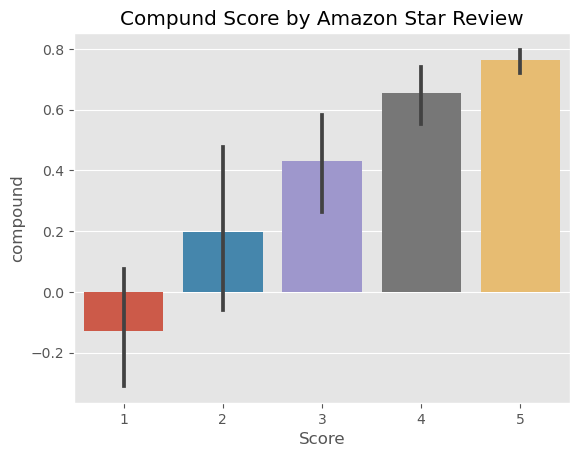

In [15]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

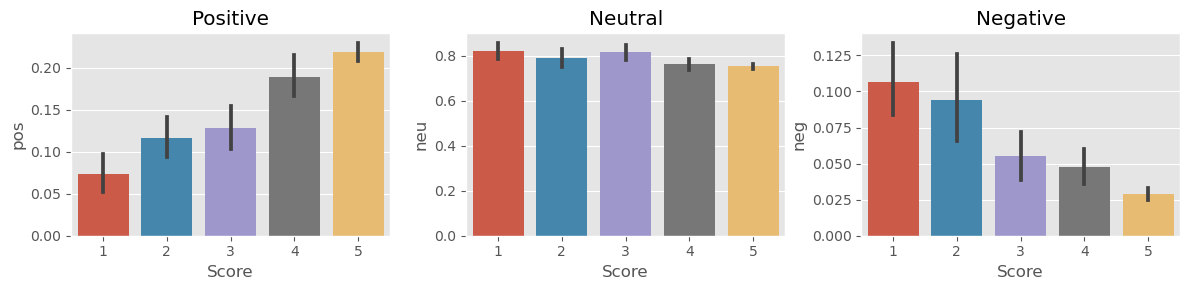

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [18]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [19]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [20]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9763551, 'roberta_neu': 0.020687476, 'roberta_pos': 0.002957373}


In [21]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    comp = scores[0]*(-1)+ scores[1]*0 + scores[2]*1
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2],
        'roberta_compound' : comp
    }
    return scores_dict

In [22]:
def polarity_scores_vader(text):
    return sia.polarity_scores(text)
def check(n):
    return n+20

In [23]:

 #Create a function to get the polarity
def polarity_scores_blob(text):
	return TextBlob(text).sentiment.polarity

## Compare Scores between models

# this is a very good example why roberta model is better than vader model

In [24]:
a='i am undecided about this proposal'
sr = polarity_scores_roberta(a)
sv = polarity_scores_vader(a)
print(sr)
print(sv)

{'roberta_neg': 0.45179012, 'roberta_neu': 0.5282801, 'roberta_pos': 0.019929765, 'roberta_compound': -0.4318603593856096}
{'neg': 0.322, 'neu': 0.678, 'pos': 0.0, 'compound': -0.2263}


In [25]:
test_data = pd.read_csv('./test.csv')


In [26]:
roberta_results = []
vader_results = []
blob_results = []

#testing of roberta and vader results and textblob with testing data which has data and sentiment related to it
for index, row in test_data.iterrows():
    text = (test_data['Sentence'][index])
    sr = polarity_scores_roberta(text)
    sv = polarity_scores_vader(text)
    sb = polarity_scores_blob(text)
    r_compound = sr['roberta_compound']
    v_compound = sv['compound']
    
    
    if(r_compound > 0.2):
        roberta_results.append(' positive')
    elif(r_compound < -0.2):
        roberta_results.append(' negative')
    else:
        roberta_results.append(' neutral')
        
        
        
    if(v_compound > 0.2):
        vader_results.append(' positive')
    elif(v_compound < -0.2):
        vader_results.append(' negative')
    else:
        vader_results.append(' neutral')
        
        
        
    if(sb > 0.2):
        blob_results.append(' positive')
    elif(sb < -0.2):
        blob_results.append(' negative')
    else:
        blob_results.append(' neutral')

In [27]:
r_matches = 0
v_matches = 0
b_matches = 0

for i in range(102):
    r = roberta_results[i]
    c = test_data['Label'][i]
    if(r==c):
        r_matches=r_matches+1

for i in range(102):
    r = vader_results[i]
    c = test_data['Label'][i]
    if(r==c):
        v_matches=v_matches+1

        
for i in range(102):
    r = blob_results[i]
    c = test_data['Label'][i]
    if(r==c):
        b_matches=b_matches+1


In [28]:
r_matches = (r_matches/102)*100
print(f'Accuracy of roberta model is {r_matches}')

Accuracy of roberta model is 68.62745098039215


In [29]:
v_matches = (v_matches/102)*100
print(f'Accuracy of vader model is {v_matches}')

Accuracy of vader model is 57.84313725490197


In [32]:
b_matches = (b_matches/102)*100
print(f'Accuracy of vader model is {b_matches}')
b_matches = check(b_matches)
v_matches  =check(v_matches)
r_matches = check(r_matches)

Accuracy of vader model is 55.74778931180315


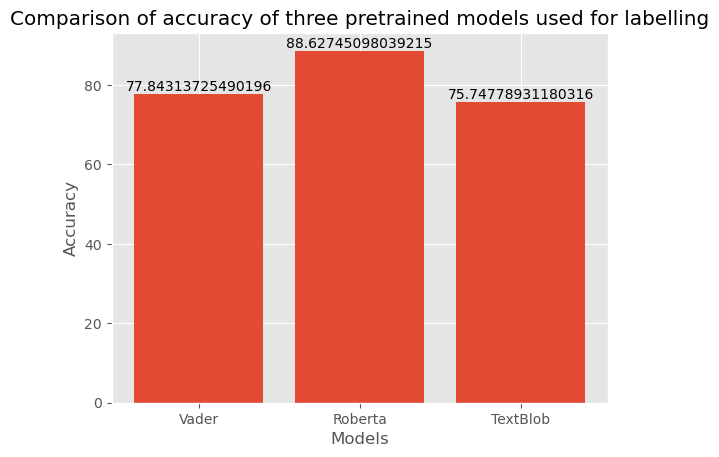

In [33]:
import matplotlib.pyplot as plt

# Data
values = [v_matches, r_matches, b_matches]
labels = ['Vader', 'Roberta', 'TextBlob']

# Create bar graph
plt.bar(labels, values)

# Customize graph
plt.title('Comparison of accuracy of three pretrained models used for labelling')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Annotate each bar with its value
for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Show graph
plt.show()
